In [0]:
import tensorflow as tf
import tensorflow.keras as keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
def import_and_authenticate():
  !pip install -U -q PyDrive
  from pydrive.auth import GoogleAuth
  from pydrive.drive import GoogleDrive
  from google.colab import auth
  from oauth2client.client import GoogleCredentials

  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  return GoogleDrive(gauth)

def get_dataset(link, drive):
  fluff, id = link.split('=')
  downloaded = drive.CreateFile({'id':id}) 
  downloaded.GetContentFile('temp.csv')  
  dataset = pd.read_csv('temp.csv')
  return dataset

def activate_drive():
  from google.colab import drive
  drive.mount('/content/gdrive')

import matplotlib.pyplot as plt
def plot_process(history, name):
  plt.figure(figsize=(15,10))
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.plot(history.history['mean_squared_error'])
  plt.plot(history.history['val_mean_squared_error'])
  plt.title('model Description')
  plt.ylabel('Error')
  plt.xlabel('epoch')
  plt.legend(['train_loss', 'test_loss','train_mean_squared_error','test_mean_squared_error'], loc='upper left')
  plt.show()
  plt.savefig(name)

In [0]:
drive = import_and_authenticate()
#train = get_dataset('https://drive.google.com/open?id=1r895ehmjNucPkcfasZgVNKFJGjKA2AKd', drive) // Not modified
train = get_dataset('https://drive.google.com/open?id=1Y2nkm8s3FAa4feA4m_ofjeiGf6VoyQ2f',drive) # Zero-filled

In [4]:
train[train['id']==4]

,date,id,cost,sold


## Renaming columns

In [0]:
train.rename(columns={'date':'created_date','sold':'item_quantity'}, inplace=True)

## Date preprocessing

In [0]:
# Casting to date column created_date
train['created_date'] = pd.to_datetime(train['created_date'], format='%Y-%m-%d')

# Fetching a year
train['day_in_year'] = train['created_date'].dt.dayofyear
minim = min(train['created_date'].dt.year)
train['year'] = train['created_date'].dt.year - minim
train.head(4)

# Linerizing a day according year
lowest_day = train[train['year']==0]['day_in_year'].min()
highest_day = train[train['year']==0]['day_in_year'].max()
train['day_number'] = train['year'] * highest_day + train['day_in_year'] - lowest_day + 5

# Week Binning
train['week'] = np.int32(train['day_number'] / 7)
train['day_of_week'] = np.int32(train['day_number'] % 7)
train.drop(columns = ['created_date','day_in_year','year','day_of_week'], inplace = True)

train = train[['id','cost','day_number','week','item_quantity']]

In [7]:
train.head()

,id,cost,day_number,week,item_quantity
0,0,350.0,5,0,0.0
1,3371,637.5,5,0,0.0
2,3370,720.0,5,0,0.0
3,3369,497.5,5,0,0.0
4,3368,292.0,5,0,0.0


## Sorting our values

In [0]:
# Sorting a values
train = train.sort_values(by = ['id','day_number']).reset_index(drop = True)

In [42]:
train.head()

,id,cost,day_number,week,item_quantity
0,0,350.0,5,0,0.0
1,0,350.0,6,0,0.0
2,0,350.0,7,1,0.0
3,0,350.0,8,1,0.0
4,0,350.0,9,1,0.0


In [45]:
test_df

,id,cost,day_number,week,item_quantity
0,0,350.0,98,14,0.0
1,0,350.0,99,14,0.0
2,0,350.0,100,14,0.0
3,0,350.0,101,14,0.0
4,0,350.0,102,14,0.0
5,0,350.0,103,14,0.0
6,0,350.0,104,14,0.0
7,0,350.0,105,15,0.0
8,0,350.0,106,15,0.0
9,0,350.0,107,15,0.0


## Train & Test

In [0]:
def split_into_train_and_test(dataset):
  last_week = dataset['week'].max() # 19 week
  dataset = dataset[dataset['week'] != last_week]

  last_week = dataset['week'].max() # 18 week
  test = dataset[dataset['week'] == last_week].copy() # 18 week
  train = dataset[dataset['week'] != last_week] # All before 18 week
  return train,test

train_df, test_df = split_into_train_and_test(train)

In [10]:
train_df.tail(4)

,id,cost,day_number,week,item_quantity
636603,5036,36.0,122,17,125.0
636604,5036,36.0,123,17,40.0
636605,5036,36.0,124,17,65.0
636606,5036,36.0,125,17,59.0


In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 597135 entries, 0 to 636606
Data columns (total 5 columns):
id               597135 non-null int64
cost             597135 non-null float64
day_number       597135 non-null int64
week             597135 non-null int32
item_quantity    597135 non-null float64
dtypes: float64(2), int32(1), int64(2)
memory usage: 25.1 MB


In [12]:
test_df.head(4)

,id,cost,day_number,week,item_quantity
121,0,350.0,126,18,0.0
122,0,350.0,127,18,0.0
123,0,350.0,128,18,0.0
124,0,350.0,129,18,0.0


## Splitting into X & y

In [0]:
def split(dataset):
  return dataset[dataset.columns.values[:-1]], dataset[dataset.columns.values[-1]]
X_train, y_train = split(train_df)
X_test, y_test = split(test_df)

## Scaler class

In [0]:
from sklearn.preprocessing import MinMaxScaler
class Scaler_3d():

  def __init__(self):
    self.__X_scaler = MinMaxScaler(feature_range=(-1, 1), copy=True)
    self.__y_scaler = MinMaxScaler(feature_range=(-1, 1), copy=True)
  
  # Fitting
  def fit(self, X_train, y_train):
    x = X_train.shape[0]
    y = X_train.shape[1]
    z = X_train.shape[2]    
    
    self.__X_scaler.fit(np.reshape(X_train, (x*y,z)))
    self.__y_scaler.fit(y_train)
  
  # scaling
  def transform(self, X, y):
    
    x_dim = X.shape[0]
    y_dim = X.shape[1]
    z_dim = X.shape[2]    
    
    X_reshaped =  np.reshape(X, (x_dim * y_dim, z_dim))
    X_reshaped_scaled = self.__X_scaler.transform(X_reshaped)
    X_scaled = np.reshape(X_reshaped_scaled, (x_dim, y_dim, z_dim))
    
    y_scaled = self.__y_scaler.transform(y)
    return X_scaled, y_scaled 
  
  def inverse_transform_X(self, X):
    x_dim = X.shape[0]
    y_dim = X.shape[1]
    z_dim = X.shape[2]    
    
    X_reshaped =  np.reshape(X, (x_dim * y_dim, z_dim))
    X_reshaped_scaled = self.__X_scaler.inverse_transform(X_reshaped)
    X_scaled = np.reshape(X_reshaped_scaled, (x_dim, y_dim, z_dim))
  
  def inverse_transform_y(self, y):
    return self.__y_scaler.inverse_transform(y)
    

## Building a sliding window for train_matrix
      + One sliding window = 4 weeks = 28 days
      + frequency of discretization: 1 day
      (# Records, # Timestamps in Rec, # of vars in one timestamp).
   
     - We have a different item_id

In [0]:
rec_size = 28 # Represents amount of previous records in current record
window_size = rec_size * train.shape[1] # Amount of records in one preprocessed record
last_id = train['id'].max()

In [0]:
def train_supervised_2_time_series(dataset, last_label, amount_of_timestamps_in_a_record, drop_zero_labeled):
  
  X_train_ = []
  y_train_ = []
  last_label += 1 # Used to include highest label
  
  for item_id in range(0, last_label):
    # Fetching table belonging to partilular id
    temp_df = dataset[dataset['id']==item_id].copy()

    # Turn to next id if no records
    if temp_df.empty: continue

    # to numpy
    matrix = temp_df.values
    
    # Clean memory
    del temp_df
    
    for i in range(amount_of_timestamps_in_a_record, matrix.shape[0]):

      # Neglecting records whose y equal to zero      
      if drop_zero_labeled and matrix[i,-1] == 0:
        continue
      else:
        # we will append the first 28 values to X
        X_train_.append(matrix[i-amount_of_timestamps_in_a_record:i, :])
        # and 28 value will be appended to y
        y_train_.append(matrix[i, -1])
  
  return np.array(X_train_), np.reshape(np.array(y_train_),(-1,1))

In [17]:
%%time
X_train, y_train = train_supervised_2_time_series(train_df, train_df['id'].max(), rec_size, True)


CPU times: user 7.2 s, sys: 120 ms, total: 7.32 s
Wall time: 7.33 s


In [18]:
y_train.shape

(36665, 1)

## Sliding window for test_matrix

In [0]:
test_df = pd.concat((train_df[train_df['week'] > 13],test_df)).sort_values(by = ['id','day_number']).reset_index(drop = True)

In [0]:
rec_size = 28 # Represents amount of previous records in current record
window_size = rec_size * test_df.shape[1] # Amount of records in one preprocessed record
last_id = train['id'].max()

In [21]:
%%time
X_test, y_test = train_supervised_2_time_series(test_df, test_df['id'].max(), rec_size, False)


CPU times: user 5.51 s, sys: 17.2 ms, total: 5.53 s
Wall time: 5.54 s


In [22]:
y_test

array([[  0.],
       [  0.],
       [  0.],
       ...,
       [120.],
       [ 76.],
       [ 35.]])

## Scaling train

In [23]:
X_test.shape

(34545, 28, 5)

In [24]:
y_test.shape

(34545, 1)

In [0]:
scaler = Scaler_3d()

# train
scaler.fit(X_train, y_train)
X_train_scaled, y_train_scaled = scaler.transform(X_train, y_train)

# test
X_test_scaled, y_test_scaled = scaler.transform(X_test, y_test)

In [26]:
X_train_scaled.shape

(36665, 28, 5)

## Model building

In [27]:
model = keras.models.load_model('FORTE_LSTM_on_zero_filled_v1.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


In [42]:
model = keras.models.Sequential()
model.add(keras.layers.LSTM(80, input_shape = (X_train_scaled.shape[1], X_train_scaled.shape[2]), activation='tanh', recurrent_activation='hard_sigmoid', use_bias=True, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=None, recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, dropout=0.0, recurrent_dropout=0.0, implementation=1, return_sequences=False, return_state=False, go_backwards=False, stateful=False, unroll=False))
model.add(keras.layers.BatchNormalization(axis = -1))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(30,use_bias = True))
model.add(keras.layers.BatchNormalization(axis = -1))
model.add(keras.layers.Activation('tanh'))
model.add(keras.layers.Dense(10,use_bias = True))
model.add(keras.layers.BatchNormalization(axis = -1))
model.add(keras.layers.LeakyReLU(alpha=0.2))
model.add(keras.layers.Dense(1,use_bias = True))
model.add(keras.layers.BatchNormalization(axis = -1))
model.add(keras.layers.LeakyReLU(alpha=0.2))
model.compile(optimizer = keras.optimizers.Adam(), loss='mean_squared_error', metrics = ['mean_absolute_error','mean_squared_error'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 80)                27520     
_________________________________________________________________
batch_normalization_v1_4 (Ba (None, 80)                320       
_________________________________________________________________
flatten_1 (Flatten)          (None, 80)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 30)                2430      
_________________________________________________________________
batch_normalization_v1_5 (Ba (None, 30)                120       
_________________________________________________________________
activation_1 (Activation)    (None, 30)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                310       
__________

In [43]:
BATCH_SIZE = 2
history = model.fit(x = X_train_scaled, y = y_train_scaled, batch_size = BATCH_SIZE, epochs = 10, validation_data = (X_test_scaled, y_test_scaled))

Train on 36665 samples, validate on 14614 samples
Epoch 1/10
36665/36665 [==============================] - 1008s 27ms/sample - loss: 0.1711 - mean_absolute_error: 0.2419 - mean_squared_error: 0.1711 - val_loss: 2.5905e-04 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 2.5905e-04
Epoch 2/10
36665/36665 [==============================] - 996s 27ms/sample - loss: 3.4406e-04 - mean_absolute_error: 0.0053 - mean_squared_error: 3.4406e-04 - val_loss: 2.5548e-04 - val_mean_absolute_error: 0.0051 - val_mean_squared_error: 2.5548e-04
Epoch 3/10
36665/36665 [==============================] - 996s 27ms/sample - loss: 3.4473e-04 - mean_absolute_error: 0.0054 - mean_squared_error: 3.4473e-04 - val_loss: 2.5672e-04 - val_mean_absolute_error: 0.0049 - val_mean_squared_error: 2.5672e-04
Epoch 4/10
36665/36665 [==============================] - 1000s 27ms/sample - loss: 3.4414e-04 - mean_absolute_error: 0.0054 - mean_squared_error: 3.4414e-04 - val_loss: 2.5659e-04 - val_mean_absolute_err

## Model saving

In [0]:
model.save('FORTE_LSTM_on_non_zero.h5')

## Visualization

In [28]:
plot_process(history, 'Linear.png')

NameError: ignored

## Predicting

In [29]:
%%time
y_test_predicted_scaled = model.predict(X_test_scaled)
y_test_predicted = scaler.inverse_transform_y(y_test_predicted_scaled)

CPU times: user 30.4 s, sys: 3.68 s, total: 34 s
Wall time: 20.7 s


In [30]:
%%time
y_train_predicted_scaled = model.predict(X_train_scaled)
y_train_predicted = scaler.inverse_transform_y(y_train_predicted_scaled)

CPU times: user 33.1 s, sys: 3.62 s, total: 36.7 s
Wall time: 22.1 s


In [31]:
y_test_predicted.shape

(34545, 1)

## Sliding window -> Standard data

In [32]:
X_train[100,]

array([[ 148., 1550.,   68.,    9.,    0.],
       [ 148., 1550.,   69.,    9.,    0.],
       [ 148., 1550.,   70.,   10.,    0.],
       [ 148., 1550.,   71.,   10.,    0.],
       [ 148., 1550.,   72.,   10.,    0.],
       [ 148., 1550.,   73.,   10.,    0.],
       [ 148., 1550.,   74.,   10.,    0.],
       [ 148., 1550.,   75.,   10.,    0.],
       [ 148., 1550.,   76.,   10.,    0.],
       [ 148., 1550.,   77.,   11.,    0.],
       [ 148., 1550.,   78.,   11.,    0.],
       [ 148., 1550.,   79.,   11.,    0.],
       [ 148., 1550.,   80.,   11.,    0.],
       [ 148., 1550.,   81.,   11.,    0.],
       [ 148., 1550.,   82.,   11.,    0.],
       [ 148., 1550.,   83.,   11.,    0.],
       [ 148., 1550.,   84.,   12.,    0.],
       [ 148., 1550.,   85.,   12.,    0.],
       [ 148., 1550.,   86.,   12.,    0.],
       [ 148., 1550.,   87.,   12.,    0.],
       [ 148., 1550.,   88.,   12.,    0.],
       [ 148., 1550.,   89.,   12.,    0.],
       [ 148., 1550.,   90.,   1

In [0]:
# 1. Fetching X record
# 2. Incrementing time stamp to one
# 3. Merging X & y records into var dataset
def time_series_2_supervised(window, label):
  """
    Given function converts a sliding window
    to just simple 
  """
  # 1. Fetching all last X records in a train
  X_rec = window[:,-1,:]

  # 2. Incrementing time stamp to one
  def incrementing_time_stamp(X):
    X[2] += 1
    X[3] = int(X[2] / 7)
    return X

  np.apply_along_axis(incrementing_time_stamp, 1, X_rec)
  
  # 3. Merging X & y records into var dataset
  return np.concatenate((X_rec, label), axis = 1)

## Restoring our dataframes

In [0]:
# 1. Transforming sliding window -> supervised
# 2. Framing into pandas dataframe.
train_predicted_df = pd.DataFrame(data = time_series_2_supervised(X_train, y_train_predicted), columns = np.append(train_df.columns.values,'item_cnt'))
test_predicted_df = pd.DataFrame(data = time_series_2_supervised(X_test, y_test_predicted), columns = np.append(test_df.columns.values,'item_cnt'))

In [0]:
#train_predicted_df.to_csv('LSTM_train_predicted.csv')
#test_predicted_df.to_csv('LSTM_test_predicted.csv')

## Filtering dataframes

In [35]:
train_predicted_df.tail(10)

,id,cost,day_number,week,item_quantity,item_cnt
36655,5036.0,36.0,116.0,16.0,70.0,177.676346
36656,5036.0,36.0,117.0,16.0,55.0,177.771088
36657,5036.0,36.0,118.0,16.0,70.0,177.782639
36658,5036.0,36.0,119.0,17.0,117.0,177.647018
36659,5036.0,36.0,120.0,17.0,90.0,177.657867
36660,5036.0,36.0,121.0,17.0,26.0,177.823761
36661,5036.0,36.0,122.0,17.0,66.0,177.774506
36662,5036.0,36.0,123.0,17.0,125.0,177.610992
36663,5036.0,36.0,124.0,17.0,40.0,177.775391
36664,5036.0,36.0,125.0,17.0,65.0,177.777618


In [36]:
test_predicted_df.tail(10)

,id,cost,day_number,week,item_quantity,item_cnt
34535,5035.0,10.010571,130.0,18.0,14.0,3.755257
34536,5035.0,10.010571,131.0,18.0,24.0,3.893201
34537,5035.0,10.010571,132.0,18.0,16.0,3.860971
34538,5036.0,36.000000,126.0,18.0,59.0,177.783005
34539,5036.0,36.000000,127.0,18.0,80.0,177.738205
34540,5036.0,36.000000,128.0,18.0,78.0,177.731598
34541,5036.0,36.000000,129.0,18.0,102.0,177.641907
34542,5036.0,36.000000,130.0,18.0,112.0,177.573792
34543,5036.0,36.000000,131.0,18.0,120.0,177.508942
34544,5036.0,36.000000,132.0,18.0,76.0,177.603821


In [0]:
# Dropping old value of y
test_predicted_df.drop(columns = [test_predicted_df.columns.values[-2]], inplace = True)
train_predicted_df.drop(columns = [train_predicted_df.columns.values[-2]], inplace = True)

## Visualization

In [0]:
train_predicted_df = train_predicted_df[['week','item_cnt']].groupby(['week']).agg({'item_cnt':'sum'}).reset_index()

In [0]:
# Grouping predicted
test_predicted_df = test_predicted_df[['week','item_cnt']].groupby(['week']).agg({'item_cnt':'sum'}).reset_index()
test_predicted_df = test_predicted_df[test_predicted_df['week'] == 18]

# Grouping actual
# Grouping a datasets with actual datas
train_grouped = train_df[['week','item_quantity']].groupby(['week']).agg({'item_quantity':'sum'}).reset_index().apply(lambda x: x)
test_grouped = test_df[['week','item_quantity']].groupby(['week']).agg({'item_quantity':'sum'}).reset_index().apply(lambda x: x)
test_grouped = test_grouped[test_grouped['week']==18]

In [52]:
test_predicted_df

,week,item_cnt
0,18.0,31899.181466


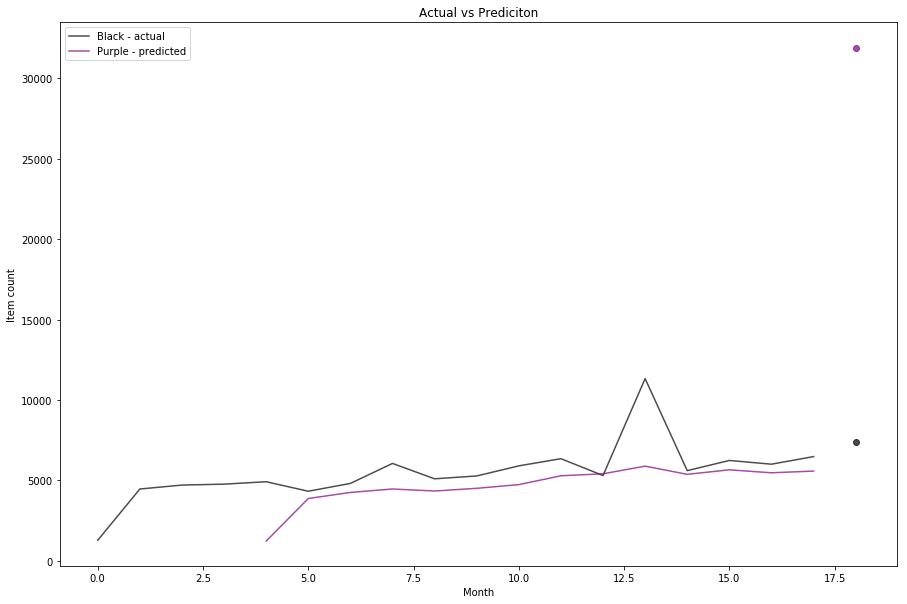

In [53]:
plt.figure(figsize=(15,10))

plt.plot(train_grouped['week'], train_grouped['item_quantity'], color = 'black', alpha = 0.7)
plt.scatter(test_grouped['week'], test_grouped['item_quantity'], color = 'black', alpha = 0.7)

plt.plot(train_predicted_df['week'], train_predicted_df['item_cnt'], color = 'purple', alpha = 0.7)
plt.scatter(test_predicted_df['week'], test_predicted_df['item_cnt'], color = 'purple', alpha = 0.7)

plt.title('Actual vs Prediciton')
plt.ylabel('Item count')
plt.xlabel('Month')
plt.legend(['Black - actual', 'Purple - predicted', ], loc='upper left')
plt.show()